In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras as keras
from matplotlib import pyplot as plt

from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Activation, Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, Reshape, Concatenate, concatenate

### 数据处理

In [44]:

data_ini = pd.read_excel('data/TJ POLTS.xlsx')

data = data_ini.iloc[:,[1,3,4,5,6,7,8]]
data.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,310,260,420,139,201,3.5,13
1,225,175,271,111,143,3.2,31
2,275,225,360,128,197,3.9,12
3,126,96,183,70,101,2.3,26
4,116,88,159,70,114,1.6,16


In [45]:

def expPreprocessing(df, alpha=0.05):
    edata = df.ewm(alpha=alpha, adjust=False).mean()
    return edata

alpha = 0.05
data_exp = expPreprocessing(data, alpha)
data_exp.head()

# alpha = 0.05
# data_exp = data.ewm(alpha=alpha, adjust=False).mean()
# data_exp.head()

,AQI,PM2.5,PM10,NO2,SO2,CO,O3_8h
0,310.000000,260.000000,420.000000,139.0000,201.000000,3.500000,13.000000
1,305.750000,255.750000,412.550000,137.6000,198.100000,3.485000,13.900000
2,304.212500,254.212500,409.922500,137.1200,198.045000,3.505750,13.805000
3,295.301875,246.301875,398.576375,133.7640,193.192750,3.445462,14.414750
4,286.336781,238.386781,386.597556,130.5758,189.233112,3.353189,14.494013


In [46]:

min_value = data_exp.min(axis=0)  
max_value = data_exp.max(axis=0)

data_std = (data_exp - min_value) / (max_value - min_value)

In [47]:


time_stamp = 50  
ratio = 0.8

split = int(ratio*len(data))
train_data = data_std[0:split + time_stamp]
valid_data = data_std[split - time_stamp:]

In [48]:
label_column = 0 
x_train, y_train = [], []
scaled_data = train_data.values

for i in range(time_stamp, len(train_data)):
    x_train.append(scaled_data[i - time_stamp:i])
    y_train.append(scaled_data[i, label_column])

x_train, y_train = np.array(x_train), np.array(y_train)



x_valid, y_valid = [], []
scaled_data = valid_data.values
for i in range(time_stamp, len(valid_data)):
    x_valid.append(scaled_data[i - time_stamp:i])
    y_valid.append(scaled_data[i, label_column])
    
x_valid, y_valid = np.array(x_valid), np.array(y_valid)

### 贝叶斯参数优化

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import optuna
def AutoformerBlock(input_layer, head_size, num_heads, ff_dim, dropout_rate):
    
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout_rate)(input_layer, input_layer)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + input_layer)

    
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(input_layer.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)

    return ffn_output

def autoformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs

    
    for _ in range(num_blocks):
        x = AutoformerBlock(x, head_size, num_heads, ff_dim, dropout_rate)

    
    x = Flatten()(x)
    outputs = Dense(1)(x)  
    return Model(inputs, outputs)

class Trainer:
    def __init__(self, x_train, y_train, x_valid, y_valid, epochs=50, batch_size=64, n_trials=100):
        self.x_train, self.y_train, self.x_valid, self.y_valid = x_train, y_train, x_valid, y_valid
        self.epochs = epochs
        self.batch_size = batch_size
        self.n_trials = n_trials
    def objective(self, trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        head_size = trial.suggest_categorical('head_size', [32, 64, 128])
        num_heads = trial.suggest_int('num_heads', 1, 4)
        ff_dim = trial.suggest_int('ff_dim', 32, 128)
        num_blocks = trial.suggest_int('num_blocks', 1, 4)
        dropout_rate = trial.suggest_uniform('dropout_rate', 0., 0.5)

        model = autoformer_model(self.x_train.shape[1:], head_size, num_heads, ff_dim, num_blocks, dropout_rate)
        optimizer = Adam(learning_rate=lr)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        y_pred = model.predict(self.x_valid)
        score = mean_squared_error(self.y_valid, y_pred)

        return score
    def optimizer_optuna(self):
        sampler = optuna.samplers.TPESampler()
        study = optuna.create_study(sampler=sampler, direction='minimize')
        study.optimize(self.objective, n_trials=self.n_trials, show_progress_bar=True)
        return study


In [50]:

epochs = 10
batch_size = 64
num_heads = 4
n_trials = 10

T = Trainer(x_train, y_train, x_valid, y_valid, epochs=epochs, batch_size=batch_size, n_trials=n_trials)
study = T.optimizer_optuna()
print(study.best_params)
print(study.best_value)

[I 2024-01-25 15:40:32,232] A new study created in memory with name: no-name-07dad776-3580-4cdd-b16d-230f4ff9e863
D:\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2024-01-25 15:40:38,308] Trial 0 finished with value: 0.0016920863524479302 and parameters: {'lr': 0.0022840571596816264, 'head_size': 32, 'num_heads': 1, 'ff_dim': 103, 'num_blocks': 2, 'dropout_rate': 0.20663346777904978}. Best is trial 0 with value: 0.0016920863524479302.
[I 2024-01-25 15:40:42,015] Trial 1 finished with value: 0.0037090157750901778 and parameters: {'lr': 0.0009606436628436028, 'head_size': 64, 'num_heads': 1, 'ff_dim': 112, 'num_blocks': 1, 'dropout_rate': 0.2928345444511165}. Best is trial 0 with value: 0.0016920863524479302.
[I 2024-01-25 15:41:07,346] Trial 2 finished with value: 0.009441155851066262 and parameters: {'lr': 0.00010836343985319645, 'head_size': 64, 'num_heads': 4, 'ff_dim': 43, 'num_blocks': 2, 'dropout_rate': 0.22480057784105295}. Best is trial 0 with value: 0.0016920863524479302.
[I 2024-01-25 15:41:15,012] Trial 3 finished with value: 0.20174050362193893 and parameters: {'lr': 1.411613011130615e-05, 'head_size': 64, 'num_heads': 2, 'ff_dim':

In [51]:

params = study.best_params
lr = params['lr']
head_size = params['head_size']
num_heads = params['num_heads']
ff_dim = params['ff_dim']
num_blocks = params['num_blocks']
dropout_rate = params['dropout_rate']
checkpoint_path_best = "data/best.hdf5"
modelcheckpoint_best = keras.callbacks.ModelCheckpoint(checkpoint_path_best,
                                                       monitor='loss',
                                                       save_best_only=True,
                                                       mode='min',
                                                       verbose=0)
#LSTM

model = autoformer_model(x_train.shape[1:], head_size, num_heads, ff_dim, num_blocks, dropout_rate)

#print(model.summary())
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
model.fit(x_train, y_train, epochs=50, batch_size=batch_size, verbose=1, callbacks=[modelcheckpoint_best])

model.load_weights(checkpoint_path_best)
closing_price = model.predict(x_valid)

Epoch 1/50
41/41 [==============================] - 1s 12ms/step - loss: 0.1695
Epoch 2/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0383
Epoch 3/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0211
Epoch 4/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0144
Epoch 5/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0110
Epoch 6/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0083
Epoch 7/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0065
Epoch 8/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0066
Epoch 9/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0057
Epoch 10/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0047
Epoch 11/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0050
Epoch 12/50
41/41 [==============================] - 1s 12ms/step - loss: 0.0044
Epoch 13/50
41/41 [==================

In [52]:
# closing_price = scaler.inverse_transform(closing_price)
# y_valid = scaler.inverse_transform([y_valid])
y_valid_list = [y_valid]

mse_2 = mean_squared_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("RMSE ", np.sqrt(mse_2))
mae = mean_absolute_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAE ", mae)
r2 = r2_score(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("R2SCORE ", r2)
mape = mean_absolute_percentage_error(y_valid_list[0], closing_price.reshape(1,-1)[0])
print("MAPE ", mape)

RMSE  0.021630581596482595
MAE  0.017463704596098206
R2SCORE  0.8003611730160783
MAPE  76334309288.7426


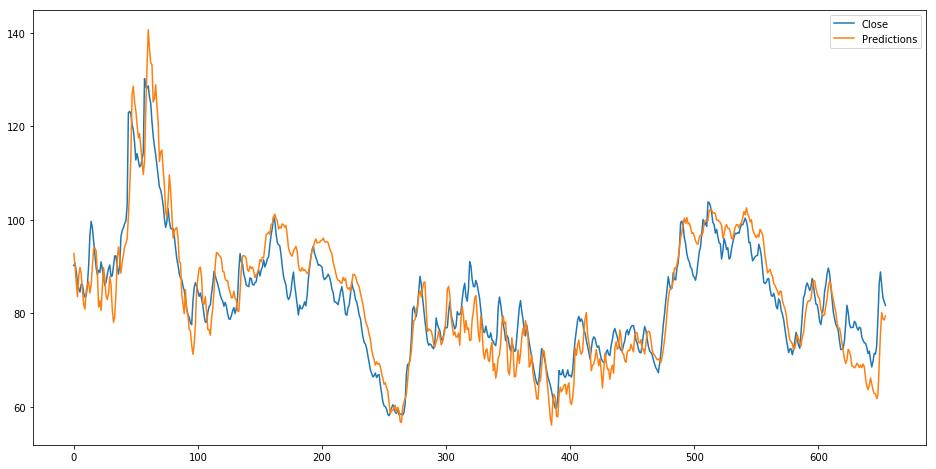

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


closing_price_original = (closing_price.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]
y_valid_original = (y_valid.reshape(-1, 1) * (max_value[label_column] - min_value[label_column])) + min_value[label_column]

plt.figure(figsize=(16, 8))
dict_data = {
    'Predictions': closing_price_original.flatten(),
    'Close': y_valid_original.flatten()
}
data_pd = pd.DataFrame(dict_data)
plt.plot(data_pd[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc='upper right')
plt.show()

pd.DataFrame(closing_price_original).to_csv('data/Autoformer_pred_TJ.csv', index=False)


In [54]:
# valid.iloc[time_stamp:,0].values == y_valid

train_labels = list(data.iloc[:split,0])   # data.iloc[split:,0]
test_labels = list(data.iloc[:,0])

prediction_values = closing_price.reshape(1,-1)[0]
prediction_exp = prediction_values * (max_value[0] - min_value[0]) + min_value[0]
prediction_list = list(prediction_exp)
all_labels = train_labels + prediction_list

labels_dict = {'prediction': all_labels, 'test': test_labels}
df_labels = pd.DataFrame(labels_dict)

In [55]:
df_labels

,prediction,test
0,310.000000,310
1,225.000000,225
2,275.000000,275
3,126.000000,126
4,116.000000,116
5,295.000000,295
6,248.000000,248
7,42.000000,42
8,109.000000,109
9,70.000000,70


In [56]:
def exp_reversed(df, alpha):
    row_0 = df.iloc[0]
    df_t_1 = df.iloc[:0].append(row_0, ignore_index=True).append(df.iloc[:-1], ignore_index=True)
    results = (df - (1-alpha)*df_t_1)/alpha
    results.iloc[0] = df.iloc[0]
    return results
    
original_labels = exp_reversed(df_labels, alpha)
original_labels

,prediction,test
0,310.000000,310.0
1,-1390.000000,-1390.0
2,1225.000000,1225.0
3,-2705.000000,-2705.0
4,-74.000000,-74.0
5,3696.000000,3696.0
6,-645.000000,-645.0
7,-3872.000000,-3872.0
8,1382.000000,1382.0
9,-671.000000,-671.0
